In [ ]:
# default_exp audio.augment

# Data augmentation for audio

> Transforms to apply data augmentation in audio tasks. Inspired by FastAudio and torch-audiomentations.

In [ ]:
#export
from __future__ import annotations

import random
import math
from collections import Counter
from fractions import Fraction
from functools import reduce
from itertools import chain, count, islice, repeat

import colorednoise
from primePy import primes

from torch import _VF
from torch.distributions import Bernoulli
import torchaudio.transforms as tatfms
import torchaudio.functional as TAF
from torchaudio.functional.functional import _get_sinc_resample_kernel, _apply_sinc_resample_kernel

from fastcore.transform import DisplayedTransform, retain_type

from fastai.data.load import DataLoader
from fastai.vision.augment import RandTransform, broadcast_vec

from fastxtend.transform import BatchRandTransform
from fastxtend.audio.core import TensorAudio, TensorSpec, TensorMelSpec
from fastxtend.imports import *

In [ ]:
#hide
from nbdev.showdoc import *

<AxesSubplot:>

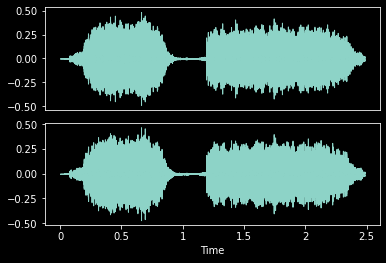

In [ ]:
#hide
from fastxtend.test_utils import *
from fastxtend.audio.data import MelSpectrogram
import matplotlib.pyplot as plt
audio = TensorAudio.create(TEST_AUDIO)
audio.show(hear=False)

## TensorAudio Transforms

In [ ]:
#exporti
def _get_audio_attr(x:TensorAudio|TensorSpec|TensorMelSpec|tuple[TensorAudio|TensorSpec|TensorMelSpec,...], attr:str) -> Any:
    if isinstance(x, tuple): return getattr(x[0], attr)
    else:                    return getattr(x, attr)

## Waveform Item Transforms

In [ ]:
#export
class Flip(RandTransform):
    order, split_idx = 5, 0
    def __init__(self, p:float=0.5): 
        super().__init__(p=p)

    def encodes(self, x:TensorAudio) -> Tensor:
        return x.fliplr()

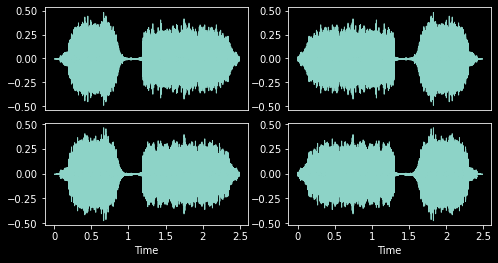

In [ ]:
with less_random():
    _,axs = plt.subplots(1,2,figsize=(8,4))
    f = Flip()
    for ax in axs: f(audio, split_idx=0).show(ctx=ax, hear=False)

### Roll -

In [ ]:
#export
class Roll(RandTransform):
    order, split_idx = 6, 0
    def __init__(self, 
        p:float=0.5,
        max_roll:float=0.5,
    ):
        store_attr('max_roll')
        super().__init__(p=p)
    
    def before_call(self,
        b:TensorAudio|tuple[TensorAudio,...],
        split_idx:int # Index of the train/valid dataset
    ):
        super().before_call(b, split_idx)
        if split_idx==0: self.shift = int(random.uniform(-1,1) * self.max_roll * _get_audio_attr(b, 'samples'))

    def encodes(self, x:TensorAudio) -> Tensor:
        return x.roll(shifts=self.shift, dims=-1)

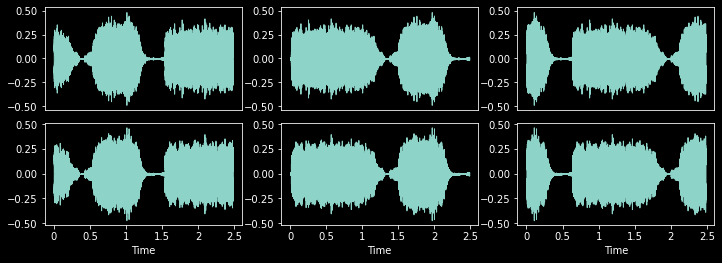

In [ ]:
with less_random():
    _,axs = plt.subplots(1,3,figsize=(12,4))
    f = Roll(p=1,max_roll=0.5)
    for ax in axs: f(audio, split_idx=0).show(ctx=ax, hear=False)

### RandomCropPad -

In [ ]:
#export
class AudioPadMode(Enum):
    "All methods of padding audio as attributes to get tab-completion and typo-proofing",
    Constant = 1
    ConstantPre = 2
    ConstantPost = 3
    Repeat = 4

In [ ]:
#exporti
@patch
def crop_pad(x:TensorAudio, 
    end_len:int,
    crop_start:int|None=None,
    pad_len:int=0, 
    padmode:AudioPadMode=AudioPadMode.Repeat,
    constant:float=0
):
    if crop_start is not None:
        x = x[...,crop_start:crop_start+end_len]
    elif pad_len:
        if padmode==AudioPadMode.ConstantPre:
            x = _VF.constant_pad_nd(x, (pad_len, 0), constant)
        elif padmode==AudioPadMode.ConstantPost:
            x = _VF.constant_pad_nd(x, (0, pad_len), constant)
        elif padmode==AudioPadMode.Repeat:
            if pad_len >= x.samples:
                x = x.repeat(1, 2+max(pad_len//x.samples, 2))
            else:
                x = torch.cat([x, x[...,0:pad_len]], dim=-1)
        elif padmode==AudioPadMode.Constant:
            if pad_len % 2 == 0: pad = pad_len//2
            else:                pad = pad_len//2 + 1
            x = _VF.constant_pad_nd(x, (pad, pad), constant)

    if x.samples > end_len:
        x = x[...,0:end_len]
    return x

In [ ]:
#export
class RandomCropPad(RandTransform):
    split_idx, order = None, 25
    def __init__(self, 
        duration:Number|None=None, # Crop length in seconds
        samples:int|None=None, # Crop length in samples
        padmode:AudioPadMode=AudioPadMode.Repeat,
        constant:Number=0
    ):
        if duration is None and samples is None:
            raise ValueError('One of `duration` or `samples` must be set')
        if constant >= 1 or constant <= -1:
            raise ValueError('`constant` must be between [-1,1]')
        if padmode not in [vol for vol in AudioPadMode]:
            raise ValueError(f"`padmode` {padmode} is not valid")
        store_attr()
        super().__init__()
    
    def before_call(self,
        b:TensorAudio|tuple[TensorAudio,...],
        split_idx:int # Index of the train/valid dataset
    ):
        self.samples = self.samples if self.samples is not None else int(self.duration*_get_audio_attr(b, 'sr'))
        self.orig_samples = _get_audio_attr(b, 'samples')
        if split_idx:
            self.crop_start = (self.orig_samples-self.samples)//2 if self.samples < self.orig_samples else None
        else:
            self.crop_start = torch.randint(0,self.orig_samples-self.samples, (1,)) if self.samples < self.orig_samples else None
        
        self.pad_len = (self.samples-self.orig_samples) if self.samples > self.orig_samples else 0

    def encodes(self, x:TensorAudio) -> Tensor:
        return x.crop_pad(self.samples, self.crop_start, self.pad_len, self.padmode, self.constant)

`RandomCropPad` will pad using one of the following five modes if the input length is less than `duration` or `samples`.

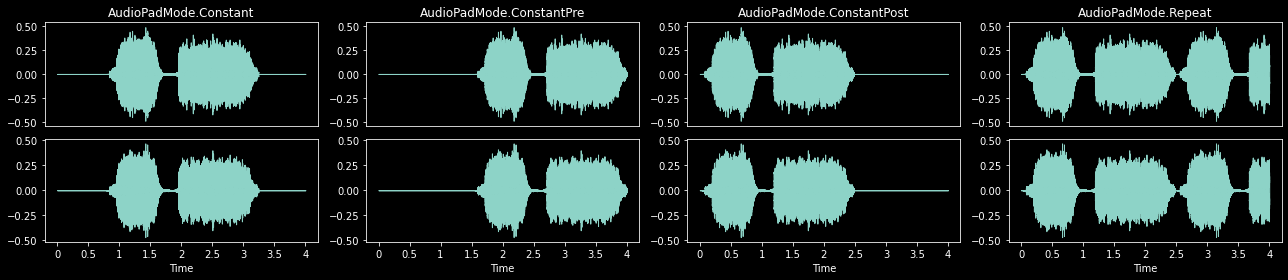

In [ ]:
with less_random():
    _,axs = plt.subplots(1,4,figsize=(18,4))
    for ax,padmode in zip(axs.flatten(), [AudioPadMode.Constant, AudioPadMode.ConstantPre,
                                          AudioPadMode.ConstantPost, AudioPadMode.Repeat]
    ):
        rcp = RandomCropPad(4, padmode=padmode)
        rcp(audio, split_idx=1).show(ctx=ax, title=padmode, hear=False)
        plt.tight_layout()

During training, `RandomCropPad` will randomly crop if the input length is greater than `duration` or `samples`.

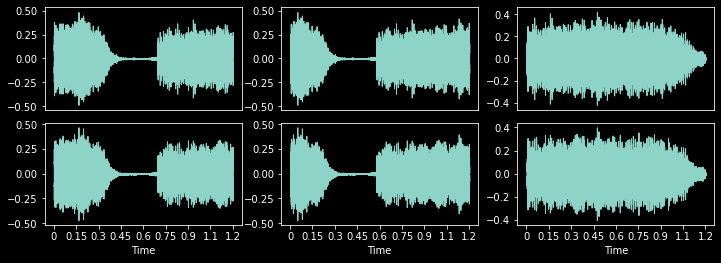

In [ ]:
with less_random():
    _,axs = plt.subplots(1,3,figsize=(12,4))
    rcp = RandomCropPad(1.2)
    for ax in axs: rcp(audio, split_idx=0).show(ctx=ax, hear=False)

During validation or prediction, `RandomCropPad` will center crop if the input length is greater than `duration` or `samples`.

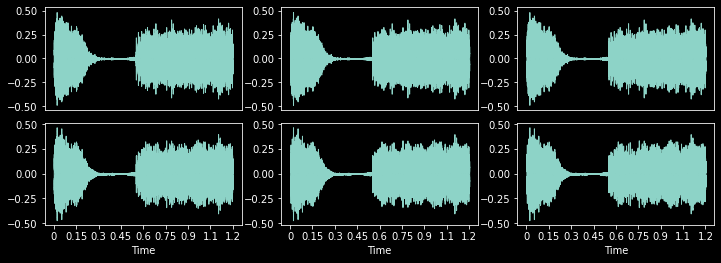

In [ ]:
with less_random():
    _,axs = plt.subplots(1,3,figsize=(12,4))
    rcp = RandomCropPad(1.2)
    for ax in axs: rcp(audio, split_idx=1).show(ctx=ax, hear=False)

### Volume -

In [ ]:
#export
class VolumeMode(Enum):
    "All AmplitudeToDB mode's as attributes to get tab-completion and typo-proofing",
    DB = 1
    Power = 2
    Amplitude = 3

In [ ]:
# export
class Volume(RandTransform):
    order, split_idx = 30, 0
    def __init__(self, 
        p:float=0.75,
        gain:Number|None=None, # If none, randomly select from `gain_range`
        gain_range:tuple[Number,Number] = (-18, 6),
        volmode:VolumeMode=VolumeMode.DB # One of "db", "amplitude", or "power"
    ): 
        super().__init__(p=p)
        store_attr(but='p')
        if volmode not in [vol for vol in VolumeMode]:
            raise ValueError(f"`vol_mode` {volmode} is not valid")
        if volmode != VolumeMode.DB:
            self.gain_range = (max(gain_range[0],0), gain_range[1])
        self._random_gain = gain is None

    def before_call(self,
        b:TensorAudio|tuple[TensorAudio,...],
        split_idx:int # Index of the train/valid dataset
    ):
        super().before_call(b, split_idx)
        if split_idx==0 and self._random_gain: self.gain = random.uniform(*self.gain_range)

    def encodes(self, x:TensorAudio) -> Tensor:
        if self.volmode == VolumeMode.DB:
            x = TAF.gain(x, self.gain)
        elif self.volmode == VolumeMode.Amplitude:
            x = x * self.gain
        elif self.volmode == VolumeMode.Power:
            x = TAF.gain(x, 10 * math.log10(self.gain))

        return torch.clamp(x, -1, 1)

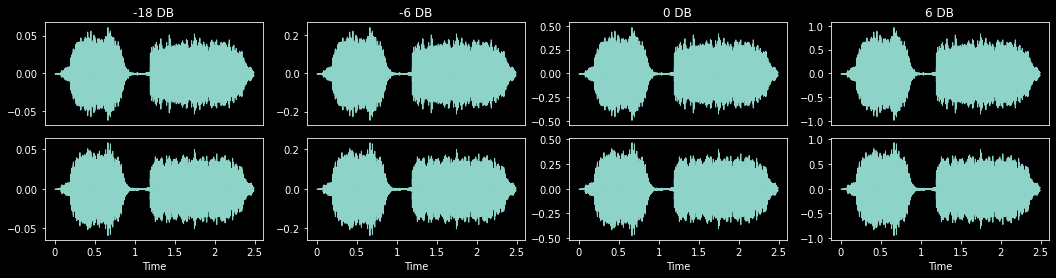

In [ ]:
_,axs = plt.subplots(1,4,figsize=(18,4))
for ax,gain in zip(axs.flatten(), [-18, -6, 0, 6]):
    vol = Volume(p=1., gain=gain)
    vol(audio, split_idx=0).show(ctx=ax, title=f'{gain} DB', hear=False)

### PeakNorm -

In [ ]:
# export
class PeakNorm(RandTransform):
    order, split_idx = 31, 0
    def __init__(self, p:float=0.1): 
        super().__init__(p=p)
        store_attr(but='p')

    def encodes(self, x:TensorAudio) -> Tensor:
            return x / torch.max(torch.abs(x))

<AxesSubplot:>

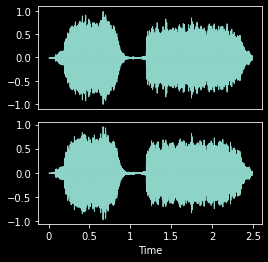

In [ ]:
_,axs = plt.subplots(1,1,figsize=(4,4))
PeakNorm(p=1.)(audio, split_idx=0).show(ctx=axs, hear=False)

### VolumeOrPeakNorm -

In [ ]:
# export
class VolumeOrPeakNorm(RandTransform):
    order, split_idx = 30, 0
    def __init__(self, 
        p:float=0.75,
        peak_p:float=0.1,
        gain:Number|None=None, # If none, randomly select from `gain_range`
        gain_range:tuple[Number,Number] = (-18, 6),
        volmode:VolumeMode=VolumeMode.DB # One of "db", "amplitude", or "power"
    ): 
        super().__init__(p=p)
        store_attr(but='p')
        if volmode not in [vol for vol in VolumeMode]:
            raise ValueError(f"`vol_mode` {volmode} is not valid")
        if volmode != VolumeMode.DB:
            self.gain_range = (max(gain_range[0],0), gain_range[1])
        self._random_gain = gain is None

    def before_call(self,
        b:TensorAudio|tuple[TensorAudio,...],
        split_idx:int # Index of the train/valid dataset
    ):
        super().before_call(b, split_idx)
        if split_idx==0:
            self.peak = torch.randn(1) < self.peak_p
            if not self.peak and self._random_gain:
                self.gain = random.uniform(*self.gain_range)

    def encodes(self, x:TensorAudio) -> Tensor:
        if self.peak:
            x = x / torch.max(torch.abs(x))
        else:
            if self.volmode == VolumeMode.DB:
                x = TAF.gain(x, self.gain)
            elif self.volmode == VolumeMode.Amplitude:
                x = x * self.gain
            elif self.volmode == VolumeMode.Power:
                x = TAF.gain(x, 10 * math.log10(self.gain))

        return torch.clamp(x, -1, 1)

### Noise -

In [ ]:
#exporti

# Noise contains code from github.com/fastaudio/fastaudio

# MIT License

# Original FastAudio implementation, Copyright (c) 2020 scart97

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

class NoiseColor(Enum):
    """Exponent beta values for named noise colors (see `colored_noise`)."""
    Violet = -2
    Blue = -1
    White = 0
    Pink = 1
    Brown = 2

In [ ]:
#export
class Noise(RandTransform):
    order, split_idx = 60, 0
    "Adds noise of specified color and level relative to mean audio level"

    def __init__(self,
        p=0.25,
        noise_level:float|None=None, # Loudness of noise, if None randomly selects from `noise_range`
        noise_range:tuple[float,float]=(0.01,0.1), # Range of noise loudness values
        color:NoiseColor|None=None, # Color of noise to add, if None randomly selects from `NoiseColor`
    ):
        super().__init__(p=p)
        store_attr(but='p')
        self._color_choice = [nc for nc in NoiseColor]
        if color is not None and color not in self._color_choice:
            raise ValueError(f"`color` {color} is not valid")
        self._random_color = color is None
        self._random_noise = noise_level is None

    def before_call(self,
        b:TensorAudio|tuple[TensorAudio,...],
        split_idx:int # Index of the train/valid dataset
    ):
        super().before_call(b, split_idx)
        if split_idx==0:
            if self._random_color: self.color = random.choice(self._color_choice)
            if self._random_noise: self.noise_level = random.uniform(*self.noise_range)

    def encodes(self, x:TensorAudio) -> Tensor:
        # if it's white noise, use torch.randn_like for speed
        if self.color == NoiseColor.White:
            noise = torch.randn_like(x)
        else:
            noise = torch.from_numpy(colorednoise.powerlaw_psd_gaussian(exponent=self.color.value, size=x.samples)).float()
        x += noise * x.abs().mean() * self.noise_level
        return x

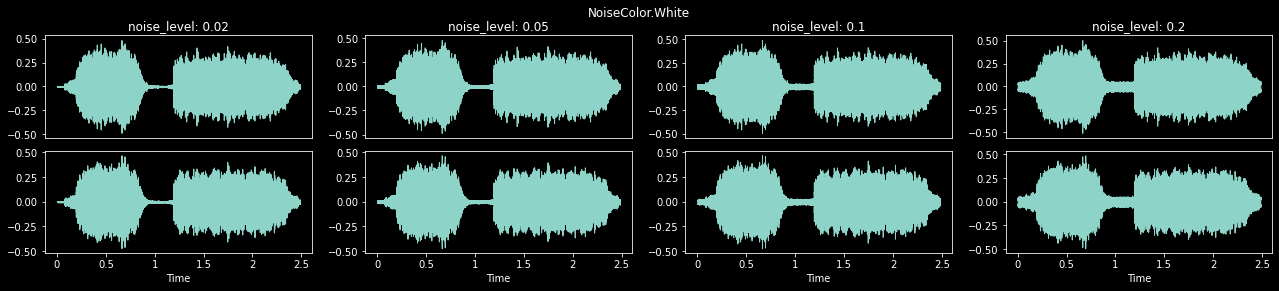

In [ ]:
with less_random():
    cn = NoiseColor.White
    _,axs = plt.subplots(1,4,figsize=(22,4))
    plt.suptitle(f'{cn}')
    for ax,nl in zip(axs.flatten(), [0.02, 0.05, 0.1, 0.2]):
        ps = Noise(p=1., noise_level=nl, color=cn)
        audio = TensorAudio.create(TEST_AUDIO)
        ps(audio, split_idx=0).show(ctx=ax, title=f'noise_level: {nl}', hear=False)

## Waveform Batch Transforms

### Volume -

In [ ]:
#export
class VolumeBatch(BatchRandTransform):
    order, split_idx = 10, 0
    def __init__(self, 
        p:float=0.5,
        gain:Number|None=None, # If none, randomly select from `gain_range`
        gain_range:tuple[Number,Number] = (-18, 6),
        volmode:VolumeMode=VolumeMode.DB # One of "db", "amplitude", or "power"
    ): 
        super().__init__(p=p)
        store_attr(but='p')
        if volmode not in [vol for vol in VolumeMode]:
            raise ValueError(f"`vol_mode` {volmode} is not valid")
        if volmode != VolumeMode.DB:
            self.gain_range = (max(gain_range[0],0), gain_range[1])
        self._random_gain = gain is None

    def before_call(self,
        b:TensorAudio|tuple[TensorAudio,...],
        split_idx:int # Index of the train/valid dataset
    ):
        super().before_call(b, split_idx)
        if split_idx==0 and self._random_gain: self.gain = random.uniform(*self.gain_range)

    def encodes(self, x:TensorAudio) -> Tensor:
        if self.volmode == VolumeMode.DB:
            x = TAF.gain(x, self.gain)
        elif self.volmode == VolumeMode.Amplitude:
            x = x * self.gain
        elif self.volmode == VolumeMode.Power:
            x = TAF.gain(x, 10 * math.log10(self.gain))

        return torch.clamp(x, -1, 1)

### PitchShift and TimeStretch Helpers -

In [ ]:
#exporti
# PitchShift & TimeStretch contains code from https://github.com/KentoNishi/torch-pitch-shift and https://github.com/KentoNishi/torch-time-stretch, respectively

# MIT License

# Original implementation Copyright (c) 2021 Kento Nishi

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

In [ ]:
#exporti

# https://stackoverflow.com/a/46623112/9325832
def _combinations_without_repetition(r, iterable=None, values=None, counts=None):
    if iterable:
        values, counts = zip(*Counter(iterable).items())

    f = lambda i, c: chain.from_iterable(map(repeat, i, c))
    n = len(counts)
    indices = list(islice(f(count(), counts), r))
    if len(indices) < r:
        return
    while True:
        yield tuple(values[i] for i in indices)
        for i, j in zip(reversed(range(r)), f(reversed(range(n)), reversed(counts))):
            if indices[i] != j:
                break
        else:
            return
        j = indices[i] + 1
        for i, j in zip(range(i, r), f(count(j), counts[j:])):
            indices[i] = j

In [ ]:
#exporti
def _get_fast_shifts(
    sample_rate:int, # Audio sample rate
    condition:Callable[...,bool]=lambda x: x >= 0.5 and x <= 2 and x != 1, # Function to validate fast shift ratios
) -> list[Fraction]: # Fast pitch-shift target ratios
    "Search for pitch-shift targets that can be computed quickly for a given sample rate"
    fast_shifts = set()
    factors = primes.factors(sample_rate)
    products = []
    for i in range(1, len(factors) + 1):
        products.extend(
            [
                reduce(lambda x, y: x * y, x)
                for x in _combinations_without_repetition(i, iterable=factors)
            ]
        )
    for i in products:
        for j in products:
            f = Fraction(i, j)
            if condition(f):
                fast_shifts.add(f)
    return list(fast_shifts)

In [ ]:
#exporti
def _semitones_to_ratio(semitones:float) -> Fraction:
    "Convert semitonal shifts into a Fraction indicating a pitch shift ratio"
    return Fraction(2.0 ** (semitones / 12.0))

In [ ]:
#exporti
def _get_fast_stretches(
    sample_rate:int, # Audio sample rate
    condition:Callable[...,bool]=lambda x: x >= 0.5 and x <= 2 and x != 1, # Function to validate fast stretch ratios.
) -> list[Fraction]: # Fast time-stretch target ratios
    "Search for time-stretch targets that can be computed quickly for a given sample rate"
    fast_shifts = set()
    factors = primes.factors(sample_rate)
    products = []
    for i in range(1, len(factors) + 1):
        products.extend(
            [
                reduce(lambda x, y: x * y, x)
                for x in _combinations_without_repetition(i, iterable=factors)
            ]
        )
    for i in products:
        for j in products:
            f = Fraction(i, j)
            if condition(f):
                fast_shifts.add(f)
    return list(fast_shifts)

### PitchShift -

In [ ]:
#exporti
@patch
def pitch_shift(x:TensorAudio, n_fft, hop_length, shift, sr, new_sr, gcd, kernel, width, padmode, constant, device):
    shape = x.shape
    x = x.reshape(shape[0] * shape[1], shape[2])
    x = torch.stft(x, n_fft, hop_length, return_complex=True)
    phase_advance = torch.linspace(0, math.pi * hop_length, x.shape[1], device=device)[..., None]
    x = TAF.phase_vocoder(x, float(1 / shift), phase_advance)
    phase_advance = None
    x = torch.istft(x, n_fft, hop_length)
    x = retain_type(_apply_sinc_resample_kernel(x, sr, new_sr, gcd, kernel, width), typ=TensorAudio)
    crop_start = torch.randint(0, x.shape[-1]-shape[-1], (1,)) if shape[-1] < x.shape[-1]  else None
    pad_len = (shape[-1]-x.shape[-1]) if shape[-1] > x.shape[-1] else 0
    return x.crop_pad(shape[-1], crop_start, pad_len, padmode, constant).reshape(*shape)

In [ ]:
#export
class PitchShift(BatchRandTransform):
    "Fast shift of `TensorAudio` pitch"
    order, split_idx = 20, 0
    def __init__(self, 
        p:float=0.2,
        semitones:tuple[float,float]=(-4.0,4.0), # Random pitch shift range in semitones to compute efficient shifts
        bins_per_octave:int=12, # Number of steps per octave
        padmode:AudioPadMode=AudioPadMode.Repeat,
        constant:Number=0,
        split:int|None=None # Apply transform to `split` items at a time. Use to prevent OOM.
    ):
        super().__init__(p=p)
        store_attr(but='p')
        self.sr = 0
        if padmode not in [vol for vol in AudioPadMode]:
            raise ValueError(f"`padmode` {padmode} is not valid")

    def before_call(self,
        b:TensorAudio|tuple[TensorAudio,...],
        split_idx:int # Index of the train/valid dataset
    ):
        super().before_call(b, split_idx)
        if not self.sr: 
            self.sr = _get_audio_attr(b, 'sr')
            self.n_fft = self.sr // 64
            self.hop_length = self.n_fft // 32
            self._fast_shifts = _get_fast_shifts(self.sr, self._validate_fast_shifts)
            self.type = _get_audio_attr(b, 'dtype')
            self.device = _get_audio_attr(b, 'device')
        if split_idx==0: 
            self.shift = random.choice(self._fast_shifts)
            if not isinstance(self.shift, Fraction):
                self.shift = 2.0 ** (float(self.shift) / self.bins_per_octave)
            self.new_sr = int(self.sr/self.shift)
            self.gcd = math.gcd(self.sr, self.new_sr)
            self.kernel, self.width = _get_sinc_resample_kernel(self.sr, self.new_sr, self.gcd,
                                                                6, 0.99, 'sinc_interpolation', 
                                                                None, self.device, self.type)

    def encodes(self, x:TensorAudio) -> Tensor:
        if self.split:
            xs = []
            for xi in retain_type(x.split(self.split), TensorAudio):
                xs.append(xi.pitch_shift(self.n_fft, self.hop_length, self.shift, self.sr, self.new_sr, 
                                         self.gcd, self.kernel, self.width, self.padmode, self.constant, self.device))
            return torch.cat(xs, dim=0)
        else:
            return x.pitch_shift(self.n_fft, self.hop_length, self.shift, self.sr, self.new_sr, 
                                 self.gcd, self.kernel, self.width, self.padmode, self.constant, self.device)

    def _validate_fast_shifts(self, x):
        return x >= _semitones_to_ratio(self.semitones[0]) and x <= _semitones_to_ratio(self.semitones[1]) and x != 1

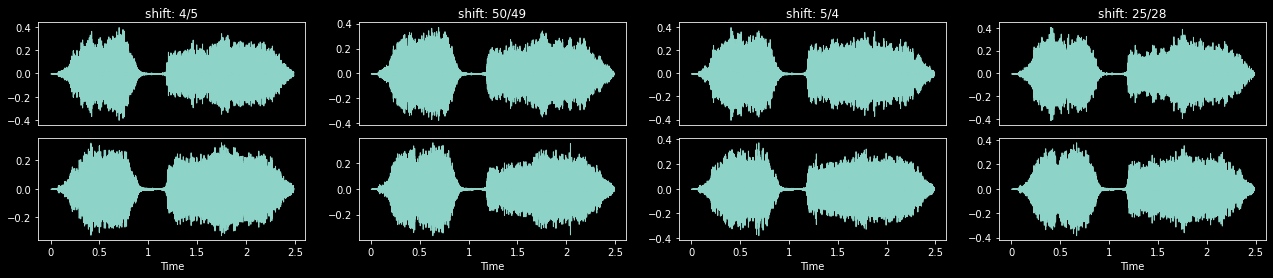

In [ ]:
with less_random():
    _,axs = plt.subplots(1,4,figsize=(22,4))
    ps = PitchShift(p=1.)
    for ax in axs.flatten():
        audio = TensorAudio.create(TEST_AUDIO)
        ps(audio.unsqueeze(0), split_idx=0).squeeze(0).show(ctx=ax, title=f'shift: {ps.shift}', hear=False)

### PitchShiftTA -

In [ ]:
#export
class PitchShiftTA(BatchRandTransform):
    "Shift the TensorAudio's pitch using TorchAudio. Can be slower than `PitchShift`"
    order, split_idx = 20, 0
    def __init__(self, 
        p:float=0.2,
        n_steps:int|None=None, # The (fractional) steps to shift waveform
        n_step_range:tuple[int,int] = (2,6), # Random `n_steps` range if `n_steps` is None
        bins_per_octave:int=12, # Number of steps per octave
        n_fft:int=512, # Size of FFT, creates n_fft // 2 + 1 bins
        win_length:int|None=None, # Window size. Defaults to `n_fft`
        hop_length:int|None=None, # Length of hop between STFT windows. Defaults to `win_length` // 4
        window_fn:Callable[..., Tensor]=torch.hann_window, # Window tensor applied/multiplied to each frame/window
        wkwargs:dict|None=None, # Args for `window_fn`
    ):
        super().__init__(p=p)
        store_attr(but='p,window_fn,wkwargs')
        self.sr=0
        self.win_length = win_length if win_length is not None else n_fft
        self.hop_length = hop_length if hop_length is not None else self.win_length // 4
        self.window = window_fn(self.win_length) if wkwargs is None else window_fn(self.win_length, **wkwargs)

    def before_call(self,
        b:TensorAudio|tuple[TensorAudio,...],
        split_idx:int # Index of the train/valid dataset
    ):
        super().before_call(b, split_idx)
        if not self.sr: self.sr = _get_audio_attr(b, 'sr')
        if split_idx==0:
            self.steps = random.uniform(*self.n_step_range) if self.n_steps is None else self.n_steps

    def encodes(self, x:TensorAudio) -> Tensor:
        return TAF.pitch_shift(x, self.sr, self.steps, self.bins_per_octave, self.n_fft, 
                               self.win_length, self.hop_length, self.window)

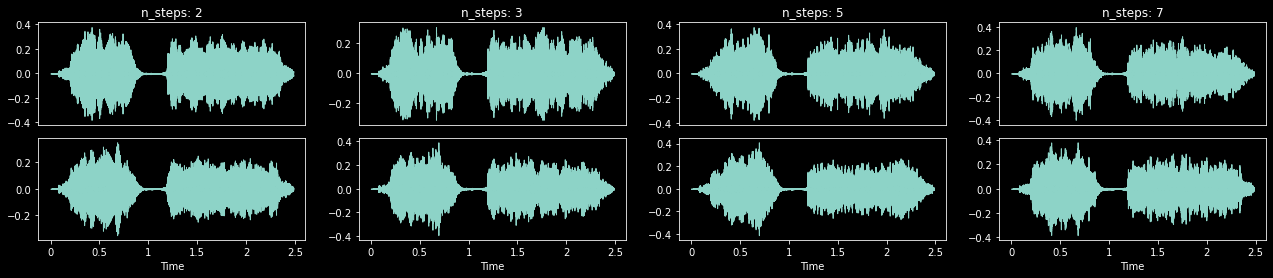

In [ ]:
_,axs = plt.subplots(1,4,figsize=(22,4))
for ax,steps in zip(axs.flatten(), [2, 3, 5, 7]):
    ps = PitchShiftTA(p=1., n_steps=steps)
    audio = TensorAudio.create(TEST_AUDIO)
    ps(audio.unsqueeze(0), split_idx=0).squeeze(0).show(ctx=ax, title=f'n_steps: {steps}', hear=False)

### TimeStretch -

In [ ]:
#exporti
@patch
def time_stretch(x:TensorAudio, n_fft, hop_length, stretch, padmode, constant, device):
    shape = x.shape
    x = x.reshape(shape[0] * shape[1], shape[2])
    x = torch.stft(x, n_fft, hop_length, return_complex=True)
    phase_advance = torch.linspace(0, math.pi * hop_length, x.shape[1], device=device)[..., None]
    x = TAF.phase_vocoder(x, float(1/stretch), phase_advance)
    phase_advance = None
    x = torch.istft(x, n_fft, hop_length)
    crop_start = torch.randint(0, x.shape[-1]-shape[-1], (1,)) if shape[-1] < x.shape[-1]  else None
    pad_len = (shape[-1]-x.shape[-1]) if shape[-1] > x.shape[-1] else 0
    return x.crop_pad(shape[-1], crop_start, pad_len, padmode, constant).reshape(*shape)

In [ ]:
#export
class TimeStretch(BatchRandTransform):
    "Fast time stretch of `TensorAudio`"
    order, split_idx = 25, 0
    def __init__(self, 
        p:float=0.2,
        stretch_rates:tuple[float,float]=(0.5,2.0), # Random time stretch range to compute efficient stretches. Defaults to 50%-200% speed
        padmode:AudioPadMode=AudioPadMode.Repeat,
        constant:Number=0,
        split:int|None=None # Apply transform to `split` items at a time. Use to prevent OOM.
    ):
        super().__init__(p=p)
        store_attr(but='p')
        self.sr = 0
        if padmode not in [vol for vol in AudioPadMode]:
            raise ValueError(f"`padmode` {padmode} is not valid")

    def before_call(self,
        b:TensorAudio|tuple[TensorAudio,...],
        split_idx:int # Index of the train/valid dataset
    ):
        super().before_call(b, split_idx)
        if not self.sr: 
            self.sr = _get_audio_attr(b, 'sr')
            self.n_fft = self.sr // 64
            self.hop_length = self.n_fft // 32
            self._fast_stretchs = _get_fast_stretches(self.sr, self._validate_fast_stretches)
            self.device = _get_audio_attr(b, 'device')
        if split_idx==0: 
            self.stretch = float(1/random.choice(self._fast_stretchs))

    def encodes(self, x:TensorAudio) -> Tensor:
        if self.split:
            xs = []
            for xi in retain_type(x.split(self.split), TensorAudio):
                xs.append(xi.time_stretch(self.n_fft, self.hop_length, self.stretch, self.padmode, self.constant, self.device))
            return torch.cat(xs, dim=0)
        else:
            return x.time_stretch(self.n_fft, self.hop_length, self.stretch, self.padmode, self.constant, self.device)


    def _validate_fast_stretches(self, x):
        return x >= self.stretch_rates[0] and x <= self.stretch_rates[1] and x != 1

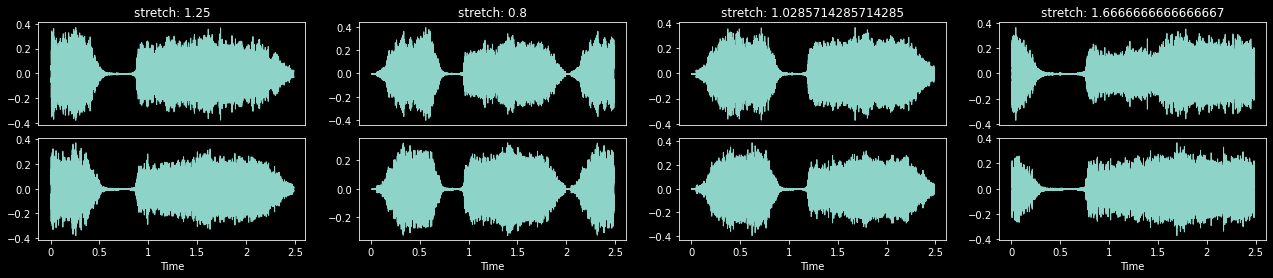

In [ ]:
with less_random():
    _,axs = plt.subplots(1,4,figsize=(22,4))
    ts = TimeStretch(p=1.)
    for ax in axs.flatten():
        audio = TensorAudio.create(TEST_AUDIO)
        ts(audio.unsqueeze(0), split_idx=0).squeeze(0).show(ctx=ax, title=f'stretch: {ts.stretch}', hear=False)

### PitchShiftOrTimeStretch -

In [ ]:
#export
class PitchShiftOrTimeStretch(BatchRandTransform):
    "Either `PitchShift` or `TimeStretch` `TensorAudio` to minimize distortion"
    order, split_idx = 25, 0
    def __init__(self, 
        p:float=0.4,
        semitones:tuple[float,float]=(-4.0,4.0), # Random pitch shift range in semitones to compute efficient shifts
        bins_per_octave:int=12, # Number of steps per octave
        stretch_rates:tuple[float,float]=(0.5,2.0), # Random time stretch range to compute efficient stretches. Defaults to 50%-200% speed
        padmode:AudioPadMode=AudioPadMode.Repeat, # 
        constant:Number=0, # Constant padding value
        split:int|None=None # Apply transform to `split` items at a time. Use to prevent OOM.
    ):
        super().__init__(p=p)
        if padmode not in [vol for vol in AudioPadMode]:
            raise ValueError(f"`padmode` {padmode} is not valid")
        self.bernoulli = Bernoulli(.5)
        self.shift   = PitchShift(1., semitones, bins_per_octave, padmode, constant, split)
        self.stretch = TimeStretch(1., stretch_rates, padmode, constant, split)

    def encodes(self, x:TensorAudio) -> Tensor:
        self.shift_smpl = self.bernoulli.sample((x.shape[0],))
        self.stretchs_smpl = (self.shift_smpl - 1) *-1
        self.shift_idxs, self.stretch_idxs = self.shift_smpl.bool(), self.stretchs_smpl.bool()
        if self.shift_smpl.sum() > 0:
            x[self.shift_idxs] = self.shift(x[self.shift_idxs], split_idx=0)
        if self.stretchs_smpl.sum() > 0:
            x[self.stretch_idxs] = self.stretch(x[self.stretch_idxs], split_idx=0)
        return x

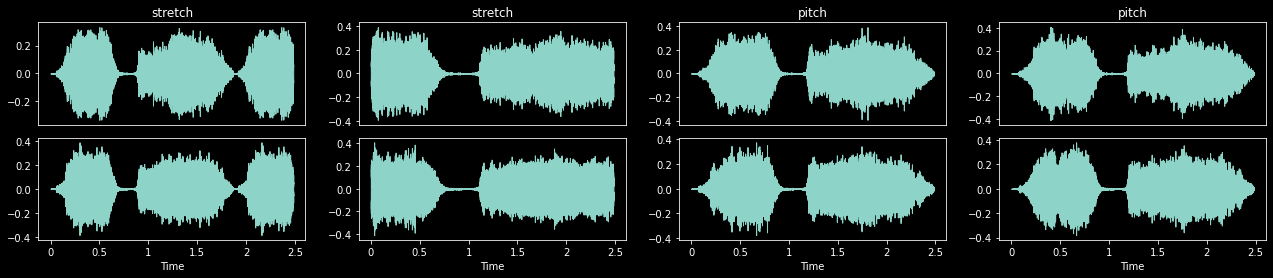

In [ ]:
with less_random(2998):
    _,axs = plt.subplots(1,4,figsize=(22,4))
    psts = PitchShiftOrTimeStretch(p=1.)
    for ax in axs.flatten():
        audio = TensorAudio.create(TEST_AUDIO)
        psts(audio.unsqueeze(0), split_idx=0).squeeze(0).show(ctx=ax, title='stretch' if sum(psts.stretch_idxs) else 'pitch', hear=False)

## TensorMelspec Transforms
All are batch transforms

<AxesSubplot:>

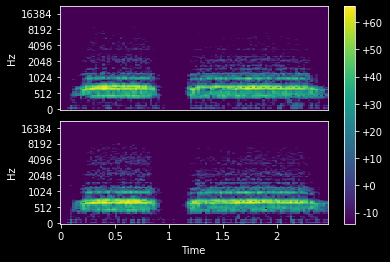

In [ ]:
# audio = TensorAudio.create(TEST_AUDIO)
mel = MelSpectrogram(audio.sr, hop_length=1024, n_fft=1024, n_mels=112)(audio)
mel.show(to_db=True)

### TimeMasking -

In [ ]:
#export
class TimeMasking(BatchRandTransform):
    split_idx, order = 0, 81
    def __init__(self,
        p:float=0.25, # Per-item probability
        max_mask:float=0.2, # Maximum possible length of the mask  [0, max_mask)
        iid_masks:bool=True, # Apply different masks to each example/channel in the batch
        mask_value:int|None=0 # If None, random value between batch min and max
    ):
        store_attr(but='p')
        super().__init__(p=p)

    def encodes(self, x:TensorSpec|TensorMelSpec) -> Tensor:
        mask_param = int(self.max_mask * x.shape[-1])
        mv = random.randint(int(x.min), int(x.max)) if self.mask_value is None else self.mask_value
        if self.iid_masks and x.dim() == 4:
            return TAF.mask_along_axis_iid(x, mask_param, mv, 3)
        else:
            return TAF.mask_along_axis(x, mask_param, mv, 2)

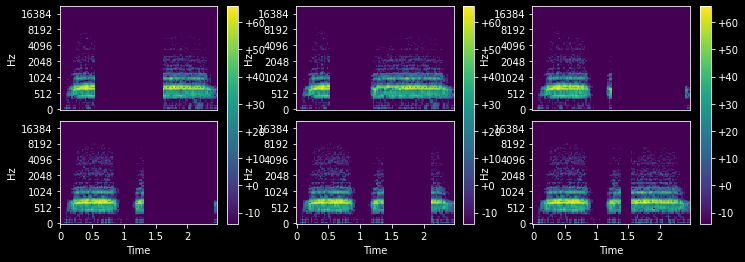

In [ ]:
with less_random():
    _,axs = plt.subplots(1,3,figsize=(12,4))
    tm = TimeMasking(p=1., max_mask=0.5)
    for ax in axs: 
        mel = MelSpectrogram(audio.sr, hop_length=1024, n_fft=1024, n_mels=112)(audio)
        tm(mel.unsqueeze(0), split_idx=0).squeeze(0).show(ctx=ax, to_db=True)

### FrequencyMasking -

In [ ]:
#export
class FrequencyMasking(BatchRandTransform):
    split_idx, order = 0, 82
    def __init__(self,
        p:float=0.25, # Per-item probability
        max_mask:float=0.2, # Maximum possible length of the mask [0, max_mask)
        iid_masks:bool=True, # Apply different masks to each example/channel in the batch
        mask_value:int|None=0 # If None, random value between batch min and max 
    ):
        store_attr(but='p')
        super().__init__(p=p)

    def encodes(self, x:TensorSpec|TensorMelSpec) -> Tensor:
        mask_param = int(self.max_mask * x.shape[-2])
        mv = random.randint(int(x.min), int(x.max)) if self.mask_value is None else self.mask_value
        if self.iid_masks and x.dim() == 4:
            return TAF.mask_along_axis_iid(x, mask_param, mv, 2)
        else:
            return TAF.mask_along_axis(x, mask_param, mv, 1)

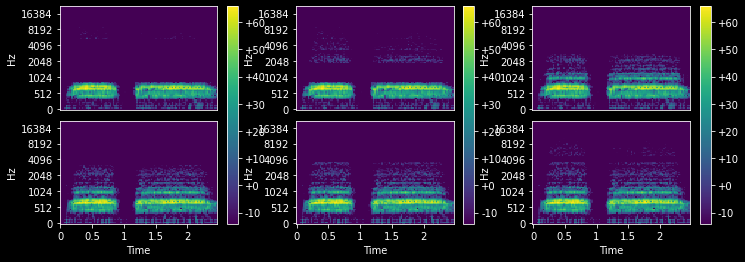

In [ ]:
with less_random():
    _,axs = plt.subplots(1,3,figsize=(12,4))
    fm = FrequencyMasking(p=1., max_mask=0.5)
    for ax in axs:
        mel = MelSpectrogram(audio.sr, hop_length=1024, n_fft=1024, n_mels=112)(audio)
        fm(mel.unsqueeze(0), split_idx=0).squeeze(0).show(ctx=ax, to_db=True)

### SpecAugment -

### AmplitudeToDB -

In [ ]:
#export
class AmplitudeToDBMode(Enum):
    "All AmplitudeToDB mode's as attributes to get tab-completion and typo-proofing",
    Power = 'power'
    Magnitude = 'magnitude'

In [ ]:
#export
class AmplitudeToDB(DisplayedTransform):
    order = 98
    def __init__(self,
        top_db:float|None=None,
        mode:AmplitudeToDBMode=AmplitudeToDBMode.Power
    ):
        self.amdb = tatfms.AmplitudeToDB(mode.value, top_db)

    def encodes(self, x:TensorSpec|TensorMelSpec) -> Tensor:
        return self.amdb(x)

    def to(self, *args, **kwargs):
        device, dtype, non_blocking, convert_to_format = torch._C._nn._parse_to(*args, **kwargs)
        self.amdb.to(device)

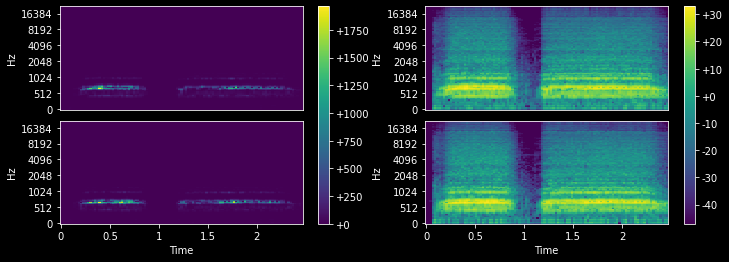

In [ ]:
with less_random():
    _,axs = plt.subplots(1,2,figsize=(12,4))
    adb = AmplitudeToDB(top_db=80)
    for i, ax in enumerate(axs):
        if i==1:
            mel = MelSpectrogram(audio.sr, hop_length=1024, n_fft=1024, n_mels=112)(audio)
            adb(mel.unsqueeze(0), split_idx=0).squeeze(0).show(ctx=ax)
        else:
           mel = MelSpectrogram(audio.sr, hop_length=1024, n_fft=1024, n_mels=112)(audio)
           mel.show(ctx=ax)

### Normalize -

In [ ]:
#export
class AudioNormalize(DisplayedTransform):
    "Normalize/denorm batch of `TensorSpec` or `TensorMelSpec`."
    parameters,order = L('mean', 'std'),99
    def __init__(self, mean=None, std=None, n_spec=1, axes=(0,2,3)): 
        store_attr()
        self.c = 0

    @classmethod
    def from_stats(cls, mean, std, n_spec=1, dim=1, ndim=4, cuda=True): 
        return cls(*broadcast_vec(dim, ndim, mean, std, cuda=cuda), n_spec=n_spec)

    def setups(self, dl:DataLoader):
        if self.mean is None or self.std is None:
            x,*_ = dl.one_batch()
            self.mean,self.std = x.mean(self.axes, keepdim=True),x.std(self.axes, keepdim=True)+1e-7

    def encodes(self, x:TensorSpec|TensorMelSpec):
        if self.n_spec > 1:
            i = self.c*x.channels
            j = (self.c+1)*x.channels
            self.c = self.c + 1 if self.c < self.n_spec-1 else 0
            return (x-self.mean[:,i:j,...]) / self.std[:,i:j,...]
        else:
            return (x-self.mean) / self.std

    # ToDo: figure out how to handle decodes
    # def decodes(self, x:TensorSpec|TensorMelSpec):
    #     f = to_cpu if x.device.type=='cpu' else noop
    #     return (x*f(self.std) + f(self.mean))